**Target:**
*  Added Global Average Pooling one layer before the final convolution layer.

**Results:**
*  Parameters: 5,646
*  Best Training Accuracy: 99.29
*  Best Test Accuracy: 99.13

**Analysis:**
*  Parameters reduced



In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8))
        self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16)) 

        self.conv3 = nn.Sequential(nn.Conv2d(16, 8, 1, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8)) 
        self.pool1 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))   

        self.conv4 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(12))

        self.conv5 = nn.Sequential(nn.Conv2d(12, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16)) 

        self.conv6 = nn.Sequential(nn.Conv2d(16, 8, 1, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(8)) 
        
        self.conv7 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=0),nn.ReLU(inplace=True),nn.BatchNorm2d(16)) 
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6)) 
        self.conv8 = nn.Sequential(nn.Conv2d(16, 10, 1))  

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x) 
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.gap(x)
        x = self.conv8(x)        
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,168
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             136
              ReLU-8            [-1, 8, 24, 24]               0
       BatchNorm2d-9            [-1, 8, 24, 24]              16
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             876
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH : ",epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.053168848156929016 Batch_id=468 Accuracy=88.40: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9784/10000 (97.84%)

EPOCH :  1


Loss=0.048983484506607056 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9809/10000 (98.09%)

EPOCH :  2


Loss=0.03255152329802513 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9837/10000 (98.37%)

EPOCH :  3


Loss=0.010515540838241577 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9876/10000 (98.76%)

EPOCH :  4


Loss=0.03560898080468178 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 39.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9869/10000 (98.69%)

EPOCH :  5


Loss=0.014129380695521832 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9900/10000 (99.00%)

EPOCH :  6


Loss=0.051274437457323074 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:11<00:00, 39.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9901/10000 (99.01%)

EPOCH :  7


Loss=0.01707775890827179 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 39.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9898/10000 (98.98%)

EPOCH :  8


Loss=0.02309969998896122 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9907/10000 (99.07%)

EPOCH :  9


Loss=0.026399314403533936 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9897/10000 (98.97%)

EPOCH :  10


Loss=0.014186660759150982 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH :  11


Loss=0.019804680719971657 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

EPOCH :  12


Loss=0.014615694992244244 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH :  13


Loss=0.03102167695760727 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

EPOCH :  14


Loss=0.007426490541547537 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]



Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)



Text(0.5, 1.0, 'Test Accuracy')

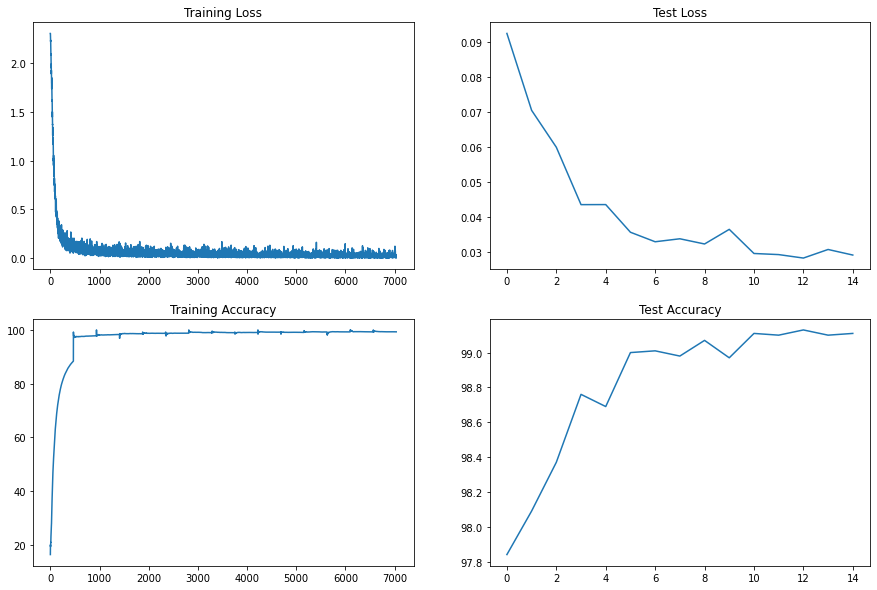

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")